# **Project Pipeline**

| **Steps**                                              | **Script files**                          |
|-----------------------------------------------------------|-------------------------------------------|
| 1) Read and pre-process data                              | pre_processing.py                         |
| 2) Feature engineering                                    | feature_engineering.py                    |
| 3) Train models                                           | model_training.py, <br>tree_model_training.py |
| 4) Predict on test_features <br>and write submission file | final_predict.py                          |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import scripts.pre_processing as pp
import scripts.feature_engineering as fe
import scripts.tree_model_training as tm
import scripts.linear_model_training as lm
from scripts.model_evaluation import regression_evaluation
import scripts.final_predict as fp

## 1) Pre-process data

In [2]:
# Read in data files 
train_features = pd.read_csv('./data/dengue_features_train.csv')
train_target = pd.read_csv('./data/dengue_labels_train.csv')
test_features = pd.read_csv('./data/dengue_features_test.csv')

In [3]:
# Merge features and target data
data = pp.merge_data(train_features, train_target, test_features, inc_test=False)

# Run processing and split by city
train_iq = pp.pre_process(data, 'iq', remove_anomalies=True, inc_test=False)
train_sj = pp.pre_process(data, 'sj', remove_anomalies=True, inc_test=False)

# Run checks for missing values
assert train_iq.isnull().any().any() == False
assert train_sj.isnull().any().any() == False
Xy_iq = train_iq.copy()
Xy_sj = train_sj.copy()
print(f'train_iq shape: {Xy_iq.shape}') 
print(f'train_sj shape: {Xy_sj.shape}') 

train_iq shape: (463, 24)
train_sj shape: (928, 24)


## 2) Feature engineering

In [4]:
# Run feature engineering 
Xy_iq = fe.cyclical_encode_date(Xy_iq)
Xy_sj = fe.cyclical_encode_date(Xy_sj)
#Xy_iq = fe.shift_features(Xy_iq, periods=1)
#Xy_sj = fe.shift_features(Xy_sj, periods=1)
Xy_iq = fe.drop_date(Xy_iq)
Xy_sj = fe.drop_date(Xy_sj)
Xy_iq = fe.add_rolling(Xy_iq, 'iq', fillna=True)
Xy_sj = fe.add_rolling(Xy_sj, 'sj', fillna=True)
Xy_iq = fe.remove_original_cols(Xy_iq)
Xy_sj = fe.remove_original_cols(Xy_sj)
print(f'train_iq shape: {Xy_iq.shape}') 
print(f'train_sj shape: {Xy_sj.shape}') 

train_iq shape: (463, 25)
train_sj shape: (928, 25)


Text(0.5, 1.0, 'San Juan Variable Correlations')

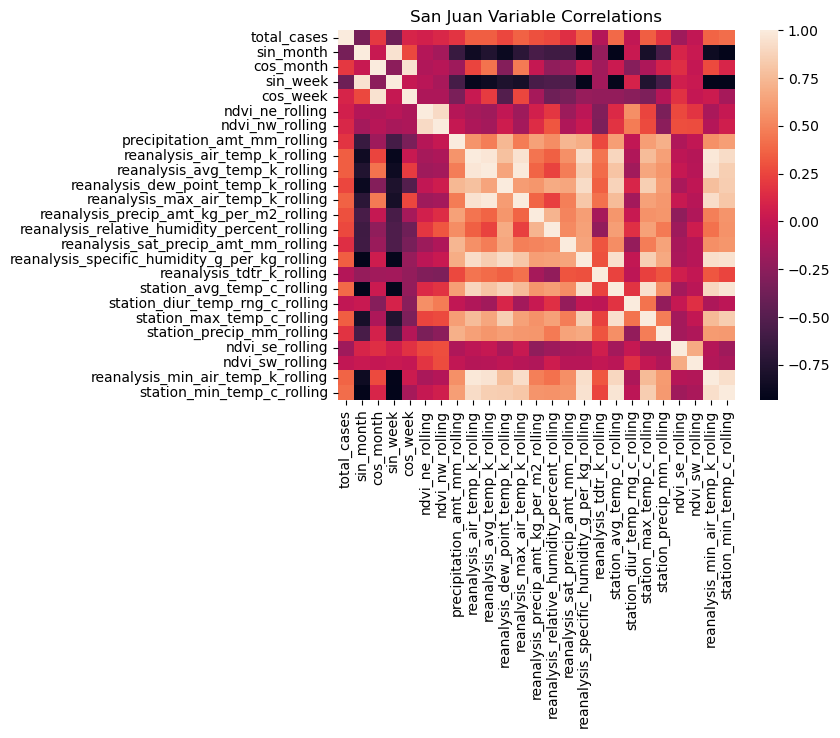

In [5]:
sj_corr_heat = sns.heatmap(Xy_sj.corr())
plt.title('San Juan Variable Correlations')


In [6]:
#(Xy_sj.total_cases
#   .drop('total_cases', axis=1) # don't compare with myself
#   .sort_values(ascending=False)
#   .plot
#   .barh())

In [6]:
# Split data into X and y
X_iq = Xy_iq.drop(labels=['total_cases'], axis=1)
y_iq = Xy_iq['total_cases']
X_sj = Xy_sj.drop(labels=['total_cases'], axis=1)
y_sj = Xy_sj['total_cases']
assert len(X_iq) == len(y_iq)

## 3) Train models

### Baseline model

In [7]:
# Baseline model predictions for Iquitos (Iq)
bl_pred_train = np.tile(np.mean(y_iq), len(y_iq))
bl_pred_test = np.tile(np.mean(y_iq), len(y_iq))
print('For Iquitos: ')
regression_evaluation(y_iq, y_iq, bl_pred_train, bl_pred_test)

# Baseline model predictions for San Jose (sj)
bl_pred_train = np.tile(np.mean(y_sj), len(y_sj))
bl_pred_test = np.tile(np.mean(y_sj), len(y_sj))
print('For San Jose: ')
regression_evaluation(y_sj, y_sj, bl_pred_train, bl_pred_test)

For Iquitos: 

    Evaluation metrics:
        RMSE train: 9.24327523359923
        RMSE test: 9.24327523359923
        MAE train: 6.380110930218457
        MAE test: 6.380110930218457 
    
For San Jose: 

    Evaluation metrics:
        RMSE train: 39.06484683794444
        RMSE test: 39.06484683794444
        MAE train: 24.198600995838284
        MAE test: 24.198600995838284 
    


(39.06484683794444, 39.06484683794444, 24.198600995838284, 24.198600995838284)

### Poisson regression model

In [8]:
# Poisson regression model for iq
X, y = X_iq, y_iq
lm.poisson_reg_model(X, y)

/opt/homebrew/Caskroom/miniforge/base/envs/DSR-comp/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/Caskroom/miniforge/base/envs/DSR-comp/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/Caskroom/miniforge/base/envs/DSR-comp/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converg

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,alpha,mat_iter
0,1,8.576190,5.316031,5.373600,3.872884,0.6,100
1,1,8.096323,4.960936,5.067012,3.647928,0.6,200
2,1,8.294175,5.123518,5.121802,3.717880,1.0,100
3,1,8.220667,5.107643,5.063550,3.717322,1.0,200
4,2,12.650234,6.336909,8.964965,4.396906,0.6,100
5,2,12.535568,6.113081,8.534592,4.315687,0.6,200
6,2,12.540463,6.216379,8.877531,4.364108,1.0,100
7,2,12.549908,6.175696,8.787398,4.325552,1.0,200


In [9]:
# Poisson regression model for sj
X, y = X_sj, y_sj
lm.poisson_reg_model(X, y)

/opt/homebrew/Caskroom/miniforge/base/envs/DSR-comp/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/Caskroom/miniforge/base/envs/DSR-comp/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/Caskroom/miniforge/base/envs/DSR-comp/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converg

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,alpha,mat_iter
0,1,87.113995,20.791679,58.765878,13.583326,0.6,100
1,1,91.896139,19.085858,63.524903,12.844904,0.6,200
2,1,82.323681,21.757303,56.833687,14.261668,1.0,100
3,1,85.281049,20.139886,57.127404,13.320107,1.0,200
4,2,31.731023,37.242385,24.354296,21.699223,0.6,100
5,2,35.168707,35.357890,26.735870,21.028602,0.6,200
6,2,33.009668,37.474315,25.169893,21.779592,1.0,100
7,2,30.473917,36.568791,23.401722,21.394172,1.0,200


<Axes: >

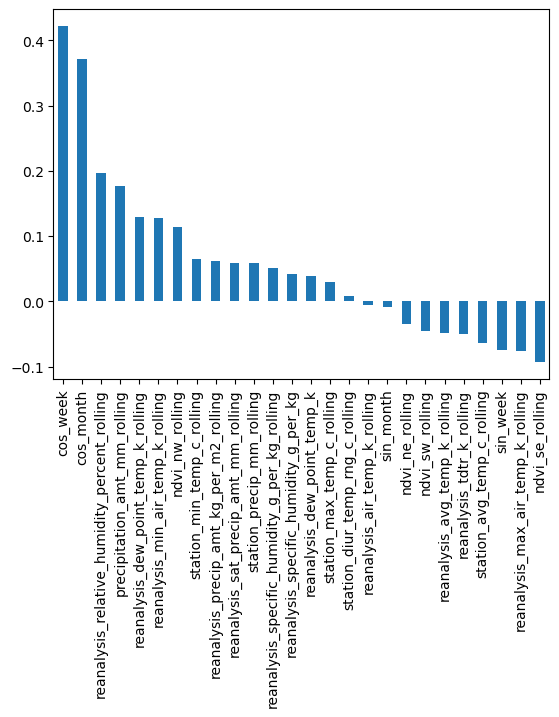

In [11]:
# Poisson get parameters for iq 
X, y = X_iq, y_iq
coefs = lm.poisson_get_coefs(X, y)
coefs.sort_values(ascending=False).plot.bar()

<Axes: >

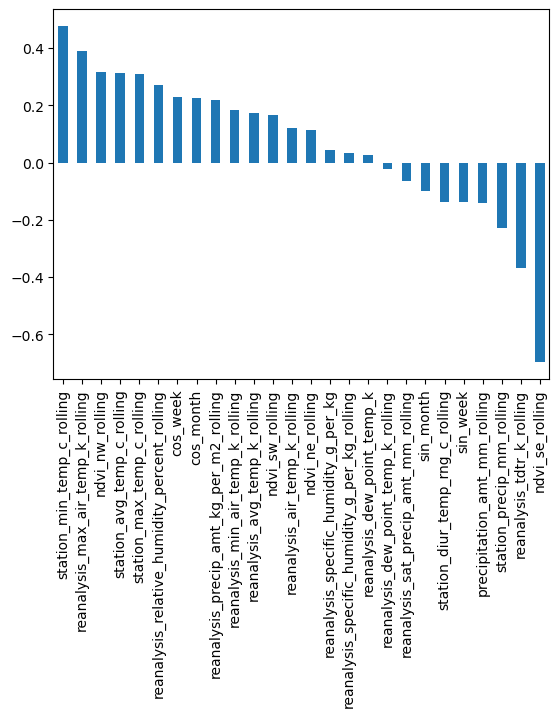

In [12]:
# Poisson get parameters for sj 
X, y = X_sj, y_sj
coefs = lm.poisson_get_coefs(X, y)
coefs.sort_values(ascending=False).plot.bar()

### Random forest model

In [10]:
# Random forest model for iq
X, y = X_iq, y_iq
tm.rforest_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,n_estimators,max_depth,min_samples_split,min_samples_leaf
0,1,8.021441,3.480087,5.332089,2.560925,100,4,2,2
1,1,8.127426,3.663695,5.425593,2.585088,100,4,5,2
2,1,8.118205,2.500238,5.395569,1.647660,100,8,2,2
3,1,8.123484,2.624509,5.321911,1.708842,100,8,5,2
4,1,8.067695,3.561737,5.309033,2.586839,200,4,2,2
5,1,8.069914,3.569618,5.349172,2.556825,200,4,5,2
6,1,8.125452,2.464675,5.421199,1.636116,200,8,2,2
7,1,7.995628,2.570681,5.281836,1.684429,200,8,5,2
8,2,11.586258,5.039225,7.147610,3.475109,100,4,2,2
9,2,11.550756,5.001928,7.262892,3.462285,100,4,5,2


In [11]:
# Random forest model for sj
X, y = X_sj, y_sj
tm.rforest_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,n_estimators,max_depth,min_samples_split,min_samples_leaf
0,1,42.416755,15.601765,30.942385,9.822011,100,4,2,2
1,1,43.892315,15.474940,31.265216,9.822121,100,4,5,2
2,1,41.703783,9.719719,30.490659,5.270852,100,8,2,2
3,1,42.188319,10.657307,28.998272,5.599125,100,8,5,2
4,1,42.697840,15.165676,31.570884,9.563661,200,4,2,2
5,1,41.704803,15.740401,29.529523,10.015128,200,4,5,2
6,1,42.131390,9.237933,29.769130,5.105916,200,8,2,2
7,1,42.994716,10.059968,31.099662,5.451700,200,8,5,2
8,2,32.441691,23.482546,28.138072,14.863239,100,4,2,2
9,2,30.840627,23.440601,26.337319,14.811344,100,4,5,2


<Axes: >

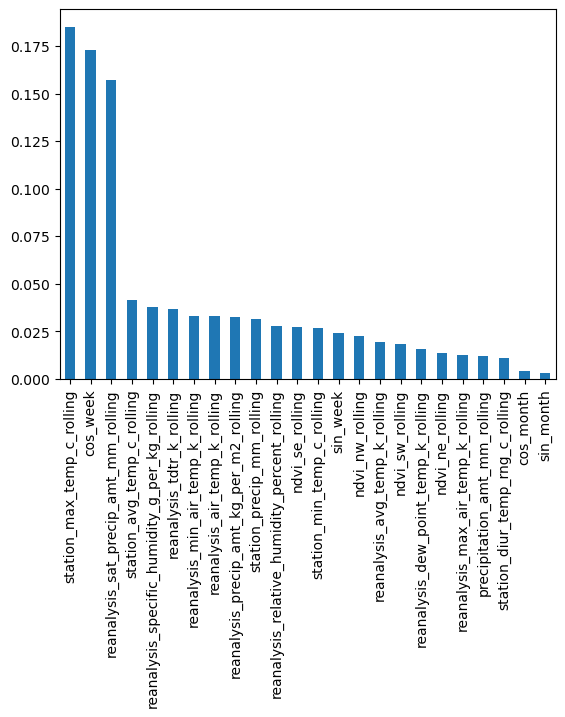

In [12]:
# Random forest feature importance for iq
X, y = X_iq, y_iq
feature_importances = tm.rf_feature_importance(X, y)
feature_importances.sort_values(ascending=False).plot.bar()

<Axes: >

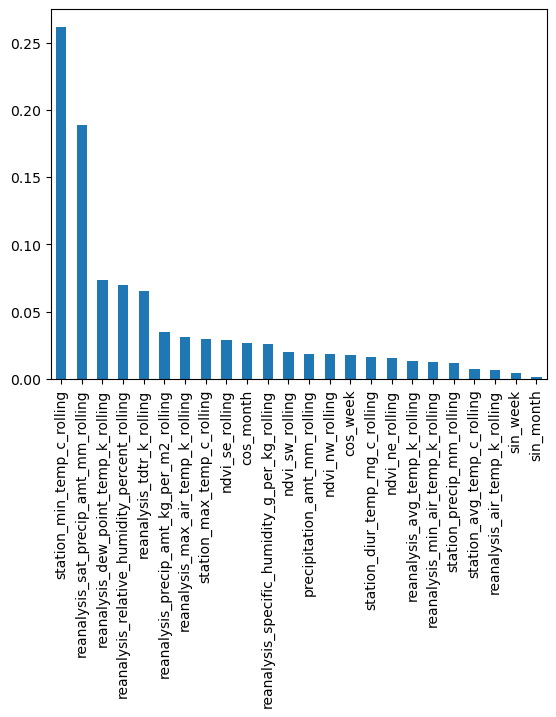

In [13]:
# Random forest feature importance for sj
X, y = X_sj, y_sj
feature_importances = tm.rf_feature_importance(X, y)
feature_importances.sort_values(ascending=False).plot.bar()

### XGBoost model

In [14]:
# XG boost model for iq
X, y = X_iq, y_iq
tm.xg_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,learning_rate,n_estimators,max_depth,subsample,colsample_bytree,reg_lambda,gamma
0,1,8.600413,2.219803,5.605889,1.321076,0.05,100,4,0.6,0.8,5,10
1,1,8.541394,2.708503,5.552896,1.612294,0.05,100,4,0.6,0.8,10,10
2,1,8.490269,3.368976,5.613201,1.935281,0.05,100,4,0.6,0.8,20,10
3,1,8.537074,2.120537,5.514380,1.221403,0.05,100,5,0.6,0.8,5,10
4,1,8.524680,2.665326,5.552544,1.530464,0.05,100,5,0.6,0.8,10,10
5,1,8.495934,3.309181,5.602130,1.860147,0.05,100,5,0.6,0.8,20,10
6,1,8.561950,2.111865,5.548569,1.230183,0.05,100,6,0.6,0.8,5,10
7,1,8.586390,2.635225,5.609285,1.512414,0.05,100,6,0.6,0.8,10,10
8,1,8.486415,3.279038,5.638157,1.839867,0.05,100,6,0.6,0.8,20,10
9,2,11.893137,2.645976,7.372844,1.753246,0.05,100,4,0.6,0.8,5,10


In [15]:
# XG boost model for sj
X, y = X_sj, y_sj
tm.xg_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,learning_rate,n_estimators,max_depth,subsample,colsample_bytree,reg_lambda,gamma
0,1,45.440403,9.331958,29.650511,4.430844,0.05,100,4,0.6,0.8,5,10
1,1,42.839264,13.450692,25.221914,5.341210,0.05,100,4,0.6,0.8,10,10
2,1,42.501496,18.488491,23.556452,6.428124,0.05,100,4,0.6,0.8,20,10
3,1,44.271167,8.907307,28.100392,3.721581,0.05,100,5,0.6,0.8,5,10
4,1,41.813552,13.270178,23.335671,4.870469,0.05,100,5,0.6,0.8,10,10
5,1,42.987198,18.251361,23.626601,6.093437,0.05,100,5,0.6,0.8,20,10
6,1,43.004718,8.796098,26.951799,3.405408,0.05,100,6,0.6,0.8,5,10
7,1,41.465678,13.157932,23.125645,4.555060,0.05,100,6,0.6,0.8,10,10
8,1,42.718087,18.171928,23.011138,5.915078,0.05,100,6,0.6,0.8,20,10
9,2,30.290822,11.641809,25.466318,6.936283,0.05,100,4,0.6,0.8,5,10


## 4) Predict on test data with chosen model and write file

Repeat the above transforms on the test set

In [16]:
# Code to run pipeline on dataset including test_features, and then take only test_features to run the final model
# Merge features and target data
data = pp.merge_data(train_features, train_target, test_features, inc_test=True)

# Run processing and split by city
Xy_iq_comb = pp.pre_process(data, 'iq', remove_anomalies=True, inc_test=True)
Xy_sj_comb = pp.pre_process(data, 'sj', remove_anomalies=True, inc_test=True)
assert Xy_iq_comb.isnull().any().any() == False
assert Xy_sj_comb.isnull().any().any() == False

# Run feature engineering 
Xy_iq_comb = fe.cyclical_encode_date(Xy_iq_comb)
Xy_sj_comb = fe.cyclical_encode_date(Xy_sj_comb)
#Xy_iq_comb = fe.shift_features(Xy_iq_comb, periods=1)
#Xy_sj_comb = fe.shift_features(Xy_sj_comb, periods=1)
Xy_iq_comb = fe.drop_date(Xy_iq_comb)
Xy_sj_comb = fe.drop_date(Xy_sj_comb)
Xy_iq_comb = fe.add_rolling(Xy_iq_comb, 'iq', fillna=True)
Xy_sj_comb = fe.add_rolling(Xy_sj_comb, 'sj', fillna=True)
Xy_iq_comb = fe.remove_original_cols(Xy_iq_comb)
Xy_sj_comb = fe.remove_original_cols(Xy_sj_comb)
print(f'Xy_iq_comb shape: {Xy_iq_comb.shape}') 
print(f'Xy_sj_comb shape: {Xy_sj_comb.shape}') 

# Split data into X and y
X_iq_comb = Xy_iq_comb.drop(labels=['total_cases'], axis=1)
y_train_iq = Xy_iq_comb.loc[Xy_iq_comb['total_cases'] >= 0, Xy_iq_comb.columns == 'total_cases']
y_test_iq = Xy_iq_comb.loc[Xy_iq_comb['total_cases'] < 0, Xy_iq_comb.columns == 'total_cases']
X_sj_comb = Xy_sj_comb.drop(labels=['total_cases'], axis=1)
y_train_sj = Xy_sj_comb.loc[Xy_sj_comb['total_cases'] >= 0, Xy_sj_comb.columns == 'total_cases']
y_test_sj = Xy_sj_comb.loc[Xy_sj_comb['total_cases'] < 0, Xy_sj_comb.columns == 'total_cases']

# Take now only the test features 
X_train_iq = X_iq_comb.iloc[:(X_iq_comb.shape[0] - y_test_iq.shape[0]) , :]
X_train_sj = X_sj_comb.iloc[:(X_sj_comb.shape[0] - y_test_sj.shape[0]) , :]
X_test_iq = X_iq_comb.iloc[(X_iq_comb.shape[0] - y_test_iq.shape[0]): , :]
X_test_sj = X_sj_comb.iloc[(X_sj_comb.shape[0] - y_test_sj.shape[0]): , :]

print(X_train_iq.shape, y_train_iq.shape)
print(X_train_sj.shape, y_train_sj.shape)
assert (X_train_iq.shape[0] == y_train_iq.shape[0])
assert (X_train_sj.shape[0] == y_train_sj.shape[0])


Xy_iq_comb shape: (619, 25)
Xy_sj_comb shape: (1188, 25)
(463, 24) (463, 1)
(928, 24) (928, 1)


In [17]:
# Select data and chosen model and hyperparameters for final prediction

params = dict(learning_rate=0.05,
        n_estimators=100,
        max_depth=5,
        subsample=0.6,
        colsample_bytree=0.8,
        reg_lambda=10,
        gamma=10)
 
# Iquitos, iq
X_test_iq = X_test_iq
X_train_iq = X_train_iq
y_train_iq = y_train_iq
model_iq = 'XGBRegressor'
params_iq = params

# San Jose, sj
X_test_sj = X_test_sj
X_train_sj = X_train_sj
y_train_sj = y_train_sj
model_sj = 'XGBRegressor'
params_sj = params


In [18]:
# Do final prediction and create final DataFrame for submission 
iq_preds = fp.final_predict(X_test_iq, X_train_iq, y_train_iq, city='iq', model=model_iq, params=params_iq)
sj_preds = fp.final_predict(X_test_sj, X_train_sj, y_train_sj, city='sj', model=model_sj, params=params_sj)
final_iq = test_features.loc[test_features.city == 'iq', ['city','year','weekofyear']]
final_sj = test_features.loc[test_features.city == 'sj', ['city','year','weekofyear']]

assert len(iq_preds) == final_iq.shape[0]
assert len(sj_preds) == final_sj.shape[0]

final_iq['total_cases'] = iq_preds.tolist()
final_sj['total_cases'] = sj_preds.tolist()
final = pd.concat([final_sj, final_iq], axis=0)
final['total_cases'] = final['total_cases'].astype(int)

assert final.isnull().any().any() == False
assert final.shape[0] == 416


In [19]:
preds_train_iq, y_train_iq = fp.preds_for_plot(X_test_iq, X_train_iq, y_train_iq, model=model_iq, params=params_iq)
preds_train_sj, y_train_sj = fp.preds_for_plot(X_test_sj, X_train_sj, y_train_sj, model=model_sj, params=params_sj)

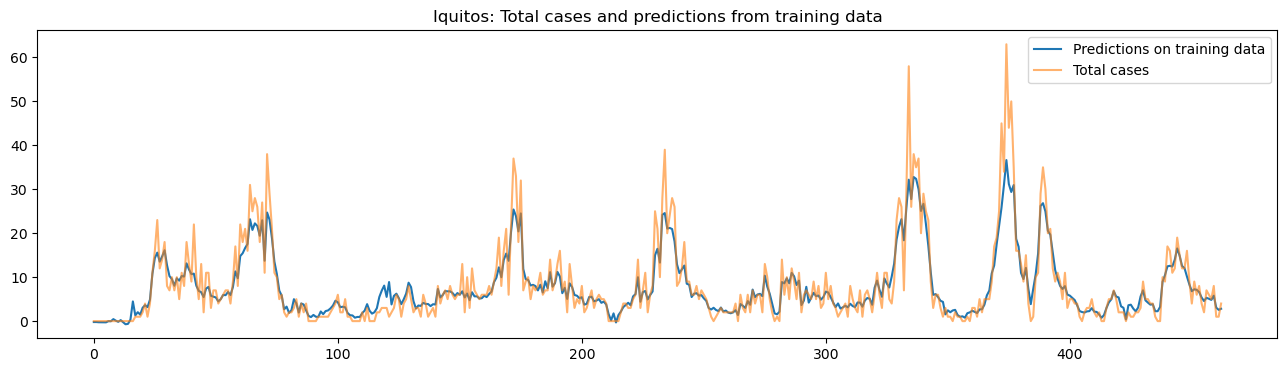

In [21]:
plt.figure(figsize=(16,4))
x = np.arange(preds_train_iq.shape[0])
plt.plot(x, preds_train_iq, label='Predictions on training data')
plt.plot(x, y_train_iq, label='Total cases', alpha=0.6)
plt.title('Iquitos: Total cases and predictions from training data')
plt.legend();

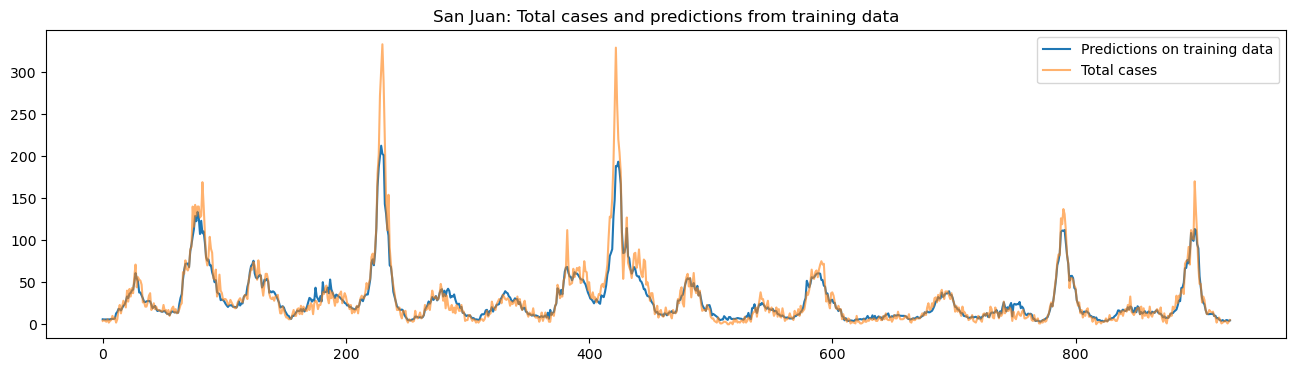

In [22]:
plt.figure(figsize=(16,4))
x = np.arange(preds_train_sj.shape[0])
plt.plot(x, preds_train_sj, label='Predictions on training data')
plt.plot(x, y_train_sj, label='Total cases', alpha=0.6)
plt.title('San Juan: Total cases and predictions from training data')
plt.legend();

In [ ]:
# Write to file for submission 
print('Writing submission file to folder: ')
final.to_csv('for_submission_XGB_no_shift.csv', index=False)